<a href="https://colab.research.google.com/github/fmarsico8/dbz-image-classifier/blob/main/TP2_T3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importar Librerias

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

In [3]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
dirname = '/content/drive/MyDrive/IA-Grupo-18/DBZ'
print(os.path.exists(dirname))  # Debería devolver True si existe
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    dirname,
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=False  # para que no mezcle si querés analizar ordenadamente
)

# Cantidad total de imágenes
total_images = train_gen.samples

# Directorios (clases)
directories = train_gen.class_indices  # dict: {class_name: index}

# Cantidad de imágenes por clase
count_per_class = {k: 0 for k in directories}
for label in train_gen.classes:
    for class_name, index in directories.items():
        if label == index:
            count_per_class[class_name] += 1
            break
print('\n--- Resumen ---')
print('Directorios leídos (clases):', len(directories))
print('Imágenes por clase:', count_per_class)
print('Total de imágenes:', total_images)


True
Found 3796 images belonging to 5 classes.

--- Resumen ---
Directorios leídos (clases): 5
Imágenes por clase: {'frieza': 852, 'muten roshi': 573, 'son gohan': 854, 'son goku': 815, 'vegeta': 702}
Total de imágenes: 3796


Crear Etiquetas


In [5]:
labels = train_gen.classes
print("Cantidad de etiquetas:", len(labels))
dbz = list(train_gen.class_indices.keys())
for idx, nombre in enumerate(dbz):
    print(idx, nombre)


Cantidad de etiquetas: 3796
0 frieza
1 muten roshi
2 son gohan
3 son goku
4 vegeta


In [6]:
y = np.array(train_gen.classes)
X_shape = (train_gen.samples, *train_gen.image_shape)
print("X.shape:", X_shape)

classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs :', nClasses)
print('Output classes :', classes)

X.shape: (3796, 64, 64, 3)
Total number of outputs : 5
Output classes : [0 1 2 3 4]


Crear set de Test y Entrenamiento

In [7]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
SEED = 42

train_gen = datagen.flow_from_directory(
    dirname,
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    dirname,
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 3039 images belonging to 5 classes.
Found 757 images belonging to 5 classes.


Creamos la red

In [16]:
INIT_LR = 1e-3
epochs = 6
batch_size = 128

# Arquitectura del modelo
dbz_model = Sequential()

# Primera capa conv
dbz_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(64, 64, 3)))
dbz_model.add(LeakyReLU())
dbz_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Segunda capa conv
dbz_model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
dbz_model.add(LeakyReLU())
dbz_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Dropout y flatten
dbz_model.add(Dropout(0.5))
dbz_model.add(Flatten())

# Capa densa más angosta
dbz_model.add(Dense(32))
dbz_model.add(LeakyReLU())
dbz_model.add(Dropout(0.5))

# Capa de salida
dbz_model.add(Dense(nClasses, activation='softmax'))

# Resumen del modelo
dbz_model.summary()

# Compilación
dbz_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),
    metrics=['accuracy']
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,597 (1.08 MB)

 Trainable params: 282,597 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos al modelo

In [13]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)


In [14]:
dbz_train = dbz_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch // train_gen.batch_size,
    validation_steps=validation_steps // val_gen.batch_size
)

Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 894s 38s/step - accuracy: 0.2565 - loss: 1.6567 - val_accuracy: 0.3104 - val_loss: 1.4900
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3806 - loss: 1.4437 - val_accuracy: 0.4531 - val_loss: 1.3461
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4576 - loss: 1.3420 - val_accuracy: 0.4914 - val_loss: 1.2472
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4988 - loss: 1.2642 - val_accuracy: 0.5469 - val_loss: 1.1811
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5301 - loss: 1.1911 - val_accuracy: 0.5456 - val_loss: 1.1645
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5577 - loss: 1.1588 - val_accuracy: 0.5641 - val_loss: 1.1221


Resultados

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5642 - loss: 1.1232
Test loss: 1.1220859289169312
Test accuracy: 0.5640686750411987


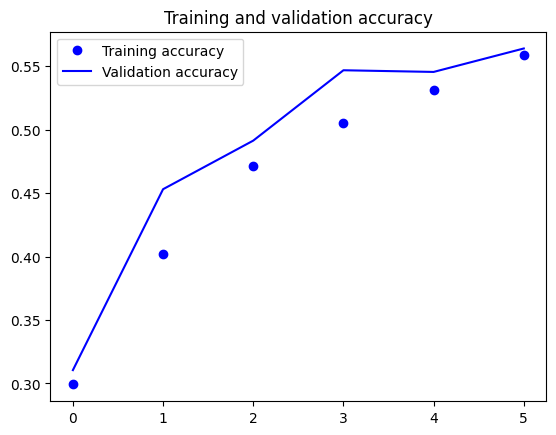

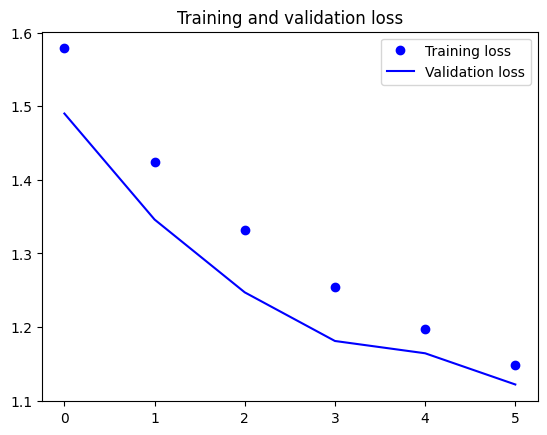

In [15]:
# Evaluamos con el conjunto de validación
test_eval = dbz_model.evaluate(val_gen, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# Extraemos el historial del entrenamiento
accuracy = dbz_train.history['accuracy']
val_accuracy = dbz_train.history['val_accuracy']
loss = dbz_train.history['loss']
val_loss = dbz_train.history['val_loss']

# Graficamos accuracy
epochs_range = range(len(accuracy))
plt.plot(epochs_range, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Graficamos pérdida (loss)
plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()